<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/Direct_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

# Data creation

In [38]:
fixed_img = np.zeros(shape=(1, 1, 128, 128, 128), dtype = np.float32)
moving_img = np.zeros(shape=(1, 1, 128, 128, 128), dtype = np.float32)

fixed_img[:, :, 32:96, 32:96, 32:96] = 1.0
moving_img[:, :, 50:114, 50:114, 50:114] = 1.0

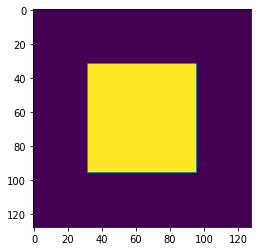

In [39]:
plt.imshow(fixed_img[0, 0, 64, :, :])

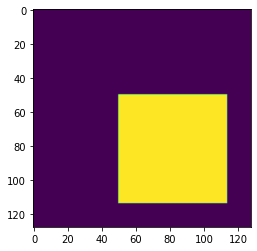

In [40]:
plt.imshow(moving_img[0, 0, 64, :, :])

In [43]:
fixed_img_tnsr = torch.from_numpy(fixed_img)
moving_img_tnsr = torch.from_numpy(moving_img)

# Model Building

In [6]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (1, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


In [61]:
rotated_affine_matrix = torch.from_numpy(np.array([ [ [0.0, 0.0, -1.0, 0.0], [ 0.0, -1.0, 0.0, 0.0], [-1.0,  0.0, 0.0, 0.0] ] ], dtype="float32" ))
affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))

In [62]:
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=affine_matrix,  affine_image_size =  (1, 1, 128, 128, 128))
print(spatial_transformer_affine.grid.shape)
print(spatial_transformer_affine.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 128, 128, 128, 3])
True
========= =========== ======



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


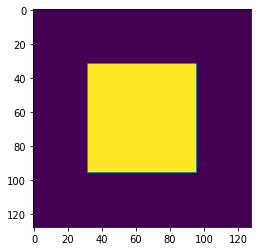

In [9]:
warped_image_tensor = spatial_transformer_affine(fixed_img_tnsr)
warped_image_np = warped_image_tensor.numpy()
plt.imshow(warped_image_np[0, 0, 40, :, :])

In [18]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [11]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

In [19]:
similarity_loss = NormalizedCrossCorrelation()
out = similarity_loss(fixed_img_tnsr, moving_img_tnsr)

In [13]:
out

tensor(0.2815)

In [63]:
myaffine = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] ], dtype="float32" ))
myaffine.requires_grad_(requires_grad=True)

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], requires_grad=True)

In [64]:
# pass tensor in [], list is iterable
optimizer = torch.optim.Adam([myaffine], lr=2e-4 ) 

In [ ]:
# do steps next - loss out and back prop it, change myaffine matrix. 

In [65]:
myaffine

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]], requires_grad=True)

# Training Loop

In [106]:
for step in range(500):

  # Update spatial transformer affine matrix with new gradient descent updated matrix
  spatial_transformer_affine.theta = myaffine

  # Find warped image given moving image from spatial transformer
  warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)

  # Find loss between warped image and fixed image
  total_loss = -1.0 * similarity_loss(fixed_img_tnsr, warped_image_tensor)
  # print(total_loss)

  # Backpropagate loss through network
  optimizer.zero_grad()          
  total_loss.backward()
  optimizer.step() 

  # Print losses
  if(step % 10 == 0):
    print("Loss at step {} is : {}".format(step, total_loss))
    print("Affine matrix is: {}".format(myaffine))
    print("============= ================ =============== =========")
    print()

  del warped_image_tensor

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Loss at step 0 is : -0.8827527761459351
Affine matrix is: tensor([[[1.0656, 0.0456, 0.0456, 0.2448],
         [0.0456, 1.0656, 0.0456, 0.2448],
         [0.0456, 0.0456, 1.0656, 0.2448]]], requires_grad=True)
============= ================ =============== =========

Loss at step 10 is : -0.8880446553230286
Affine matrix is: tensor([[[1.0625, 0.0432, 0.0432, 0.2466],
         [0.0432, 1.0625, 0.0432, 0.2466],
         [0.0432, 0.0432, 1.0625, 0.2466]]], requires_grad=True)
============= ================ =============== =========

Loss at step 20 is : -0.8934895992279053
Affine matrix is: tensor([[[1.0594, 0.0407, 0.0407, 0.2484],
         [0.0407, 1.0594, 0.0407, 0.2484],
         [0.0407, 0.0407, 1.0594, 0.2484]]], requires_grad=True)
============= ================ =============== =========

Loss at step 30 is : -0.8990345597267151
Affine matrix is: tensor([[[1.0563, 0.0382, 0.0382, 0.2502],
         [0.0382, 1.0563, 0.0382, 0.2502],
         [0.0382, 0.0382, 1.0563, 0.2502]]], require

# Inference

fixed_img[:, :, 32:96, 32:96, 32:96] = 1.0


moving_img[:, :, 50:114, 50:114, 50:114] = 1.0

In [107]:
warped_image_tensor = spatial_transformer_affine(moving_img_tnsr)
warped_image_tensor = warped_image_tensor.detach().to("cpu")
warped_image_np = warped_image_tensor.numpy()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


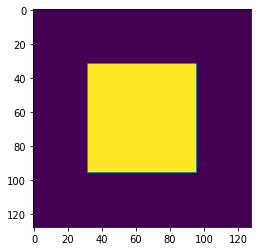

In [108]:
# 1700 iteration
plt.imshow(warped_image_np[0, 0, 38, :, :])

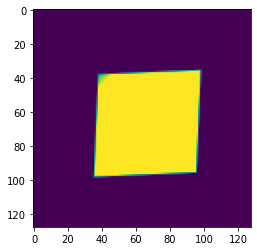

In [104]:
# 1200 iteration
plt.imshow(warped_image_np[0, 0, 38, :, :])

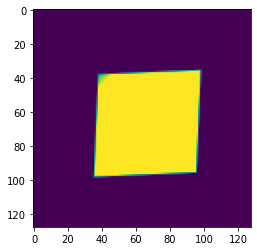

In [105]:
# 700 iteration
plt.imshow(warped_image_np[0, 0, 38, :, :])

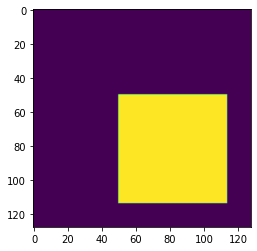

In [84]:
moving_image_np = moving_img_tnsr.numpy()
plt.imshow(moving_image_np[0, 0, 113, :, :])